👥 User-Based Collaborative Filtering
🌱 Ý tưởng:

Tìm những người dùng giống với user hiện tại dựa trên lịch sử rating,
rồi dự đoán xem user này có thể thích phim mà “hàng xóm” của họ thích.

In [2]:
# ====== QUICK RUN: user-based CF in one cell (no utils package needed) ======
import json, numpy as np, pandas as pd
from pathlib import Path
from scipy import sparse
from sklearn.neighbors import kneighbors_graph
from collections import defaultdict

In [3]:
# ---------- A. Load checkpoint ----------
BASE_DIR = r"C:\Users\ADMIN\Documents\Khóa luận\MovieTweetings Dataset\data\processed\20251102-161934"

def load_checkpoint(BASE_DIR: str):
    BASE = Path(BASE_DIR)
    data  = pd.read_parquet(BASE / "data_clean.parquet")
    folds = {
        "Fold_1": {"train": pd.read_parquet(BASE / "fold1_train.parquet"),
                   "test":  pd.read_parquet(BASE / "fold1_test.parquet")},
        "Fold_2": {"train": pd.read_parquet(BASE / "fold2_train.parquet"),
                   "test":  pd.read_parquet(BASE / "fold2_test.parquet")},
        "Fold_3": {"train": pd.read_parquet(BASE / "fold3_train.parquet"),
                   "test":  pd.read_parquet(BASE / "fold3_test.parquet")},
    }
    meta = json.load(open(BASE / "meta.json", encoding="utf-8"))
    return data, folds, meta

In [4]:
# ---------- B. Metrics ----------hàm chấm điểm top-K
def precision_recall_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    hit = sum(1 for iid in topk if iid in y_true_set)
    return hit / max(1,len(topk)), hit / max(1,len(y_true_set))

def hitrate_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    return 1.0 if any(i in y_true_set for i in topk) else 0.0

def average_precision_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    hits = ap = 0.0
    for i,iid in enumerate(topk,1):
        if iid in y_true_set:
            hits += 1; ap += hits/i
    return ap / max(1, min(len(y_true_set), k))

def dcg_at_k(rel, k):
    rel = np.asarray(rel, dtype=float)[:k]
    if rel.size==0: return 0.0
    return float(np.sum((2.0**rel - 1.0) / np.log2(np.arange(2, rel.size+2))))

def ndcg_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    rel = [1.0 if iid in y_true_set else 0.0 for iid in topk]
    dcg, idcg = dcg_at_k(rel,k), dcg_at_k(sorted(rel, reverse=True), k)
    return (dcg/idcg) if idcg>0 else 0.0

def mrr_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid,_ in y_pred_ranked[:k]]
    for i,iid in enumerate(topk,1):
        if iid in y_true_set: return 1.0/i
    return 0.0

y_true_set: tập phim user thật sự thích ở tập test (những phim họ chấm ≥ pos_thresh).
y_pred_ranked: danh sách (item_id, score) do mô hình gợi ý, đã sắp xếp giảm dần theo score.
k: chỉ lấy top-k phim đầu tiên để chấm.

Các hàm:
- precision_recall_at_k: đếm số hit trong top-K → Precision, Recall.
- Precision@K = bao nhiêu phần trăm trong top K gợi ý là đúng.
- Recall@K = bao nhiêu phần trăm phim đúng được hệ thống gợi ý trúng. 

📌 Ví dụ: user có 5 phim thật sự thích, model gợi ý top 10, trong đó 3 phim đúng ⇒ precision = 3/10, recall = 3/5.

- hitrate_at_k: hệ thống có “bắt trúng ít nhất một phim đúng” trong top-K hay không (giá trị chỉ là 0 hoặc 1) => Khi tính trung bình trên toàn bộ user, ta được tỉ lệ người dùng mà hệ thống gợi ý đúng ít nhất một phim.

- average_precision_at_k (AP@K): trung bình precision tại các vị trí đúng.
- dcg_at_k + ndcg_at_k: độ hữu ích có chiết khấu theo vị trí (nhị phân 0/1).
- mrr_at_k: chỉ quan tâm đến vị trí của phim đúng đầu tiên trong top-K chứ không cần biết phía sau còn bao nhiêu phim đúng nữa.

Tác dụng: đo chất lượng xếp hạng top-K theo nhiều góc nhìn.

In [5]:
# ---------- C. Build UI matrix + mean-center ----------
def build_ui_matrix(train_df):
    users = train_df['UserID'].astype(int).unique()
    items = train_df['MovieID'].astype(int).unique()
    user_ids = np.sort(users); item_ids = np.sort(items)
    u2row = {u:i for i,u in enumerate(user_ids)}
    i2col = {m:j for j,m in enumerate(item_ids)}

    rows = train_df['UserID'].map(u2row).to_numpy()
    cols = train_df['MovieID'].map(i2col).to_numpy()
    vals = train_df['Rating'].astype(float).to_numpy()

    U,I = len(user_ids), len(item_ids)
    R = sparse.csr_matrix((vals,(rows,cols)), shape=(U,I))

    R_centered = R.copy().tocsr()
    user_means = np.zeros(U, dtype=float)
    for u in range(U):
        s,e = R_centered.indptr[u], R_centered.indptr[u+1]
        if e>s:
            mu = R_centered.data[s:e].mean()
            R_centered.data[s:e] -= mu
            user_means[u] = mu

    seen_cols = defaultdict(set)
    for u in range(U):
        s,e = R.indptr[u], R.indptr[u+1]
        if e>s: seen_cols[u] = set(R.indices[s:e].tolist())
    return R, user_ids, item_ids, u2row, i2col, user_means, R_centered, seen_cols

In [6]:
# ---------- D. User neighbor graph (cosine) ----------
def build_user_neighbor_graph(R_centered, n_neighbors=50):
    """
    Trả về ma trận tương tự thưa W_sim (CSR, shape UxU),
    với similarity = 1 - cosine_distance, cắt âm về 0.
    """
    W_dist = kneighbors_graph(
        R_centered,
        n_neighbors=n_neighbors,
        metric='cosine',
        mode='distance',
        include_self=False,
        n_jobs=-1
    ).tocsr()

    # convert distance -> similarity, an toàn cho sparse
    W_sim = W_dist.copy().tocsr()
    # data là mảng 1D chứa các giá trị khác 0
    W_sim.data = 1.0 - W_sim.data
    # cắt âm về 0 (do sai số số học)
    W_sim.data[W_sim.data < 0.0] = 0.0
    W_sim.eliminate_zeros()
    return W_sim

In [7]:
# ---------- E. Recommend for one user ----------
def recommend_user_row(u_row, W_sim, R_centered, user_means, seen_cols, item_ids, K=20):
    W_u = W_sim.getrow(u_row)
    denom = np.abs(W_u).sum()
    if denom <= 1e-12: return []
    scores_centered = (W_u @ R_centered) / denom
    scores = scores_centered.toarray().ravel() + user_means[u_row]
    if u_row in seen_cols and len(seen_cols[u_row])>0:
        scores[list(seen_cols[u_row])] = -1e9
    K = min(K, len(scores))
    idx = np.argpartition(scores, -K)[-K:]
    idx = idx[np.argsort(scores[idx])[::-1]]
    mids = item_ids[idx]
    return list(zip(mids, scores[idx]))

In [8]:
# ---------- F. Evaluate one fold ----------
def evaluate_fold_user_based(train_df, test_df, Ks=(10,20,50), pos_thresh=7,
                             n_neighbors=50, min_train_inter=1):
    R, user_ids, item_ids, u2row, i2col, user_means, R_centered, seen_cols = build_ui_matrix(train_df)
    W_sim = build_user_neighbor_graph(R_centered, n_neighbors=n_neighbors)
    pos_test = (test_df[test_df['Rating']>=pos_thresh]
                .groupby('UserID')['MovieID'].apply(lambda s: set(s.values)).to_dict())
    users_eval = []
    for u in pos_test.keys():
        if u in u2row:
            u_row = u2row[u]
            if R.indptr[u_row+1]-R.indptr[u_row] >= min_train_inter:
                users_eval.append(u)
    if not users_eval:
        return {"users_eval": 0, "pos_thresh": pos_thresh}
    out = {"users_eval": len(users_eval), "pos_thresh": pos_thresh}
    for K in Ks:
        HR=P=Rcl=MAP=NDCG=MRR = 0.0
        for u in users_eval:
            u_row = u2row[u]
            ranked = recommend_user_row(u_row, W_sim, R_centered, user_means, seen_cols, item_ids, K=K)
            truth  = pos_test[u]
            pk, rk = precision_recall_at_k(truth, ranked, k=K)
            HR    += hitrate_at_k(truth, ranked, k=K)
            P     += pk; Rcl += rk
            MAP   += average_precision_at_k(truth, ranked, k=K)
            NDCG  += ndcg_at_k(truth, ranked, k=K)
            MRR   += mrr_at_k(truth, ranked, k=K)
        n = len(users_eval)
        out.update({
            f'hit@{K}':       float(HR/n),
            f'precision@{K}': float(P/n),
            f'recall@{K}':    float(Rcl/n),
            f'map@{K}':       float(MAP/n),
            f'ndcg@{K}':      float(NDCG/n),
            f'mrr@{K}':       float(MRR/n),
        })
    return out

In [9]:
# ---------- G. Runner ----------
data, folds, meta = load_checkpoint(BASE_DIR)
print("Loaded.", meta.get("version","?"), "| ratings:", len(data))

POS_LIST = (7, 8); KS = (10,20,50); N_NEI = 50; MIN_INT = 1
print("\n=== RUN User-Based CF (kNN cosine) ===")
ub_results = []
for fold_name in sorted(folds.keys()):
    train_df, test_df = folds[fold_name]['train'], folds[fold_name]['test']
    print(f"\n[Fold] {fold_name}: train={len(train_df):,} | test={len(test_df):,}")
    for POS in POS_LIST:
        metrics = evaluate_fold_user_based(train_df, test_df, Ks=KS, pos_thresh=POS,
                                           n_neighbors=N_NEI, min_train_inter=MIN_INT)
        metrics['fold'] = fold_name; metrics['pos_thresh'] = POS
        ub_results.append(metrics)
        present = sorted(k for k in metrics if '@' in k)
        print(f"  POS >= {POS} | users_eval={metrics.get('users_eval',0)} | "
              f"{ {k:round(metrics[k],4) for k in present} }")

ub_results_df = pd.DataFrame(ub_results)
print("\n=== Tổng hợp (mean theo pos_thresh, qua các fold) ===")
if not ub_results_df.empty:
    metric_cols = [c for c in ub_results_df.columns if any(c.startswith(m) for m in ['hit@','precision@','recall@','map@','ndcg@','mrr@'])]
    print(ub_results_df.groupby('pos_thresh')[metric_cols].mean().round(4))
else:
    print("[WARN] ub_results_df rỗng.")

Loaded. 20251102-161934 | ratings: 919019

=== RUN User-Based CF (kNN cosine) ===

[Fold] Fold_1: train=655,319 | test=263,700
  POS >= 7 | users_eval=23355 | {'hit@10': 0.1773, 'hit@20': 0.2541, 'hit@50': 0.3763, 'map@10': 0.0222, 'map@20': 0.023, 'map@50': 0.0246, 'mrr@10': 0.0735, 'mrr@20': 0.0787, 'mrr@50': 0.0826, 'ndcg@10': 0.097, 'ndcg@20': 0.1156, 'ndcg@50': 0.1386, 'precision@10': 0.022, 'precision@20': 0.0178, 'precision@50': 0.0128, 'recall@10': 0.0462, 'recall@20': 0.0676, 'recall@50': 0.1107}
  POS >= 8 | users_eval=22108 | {'hit@10': 0.1597, 'hit@20': 0.2288, 'hit@50': 0.3423, 'map@10': 0.0239, 'map@20': 0.0253, 'map@50': 0.0271, 'mrr@10': 0.0661, 'mrr@20': 0.0709, 'mrr@50': 0.0745, 'ndcg@10': 0.0874, 'ndcg@20': 0.1041, 'ndcg@50': 0.1254, 'precision@10': 0.0193, 'precision@20': 0.0153, 'precision@50': 0.0108, 'recall@10': 0.0517, 'recall@20': 0.0755, 'recall@50': 0.1223}

[Fold] Fold_2: train=698,450 | test=220,569
  POS >= 7 | users_eval=23205 | {'hit@10': 0.1628, 'hit@2

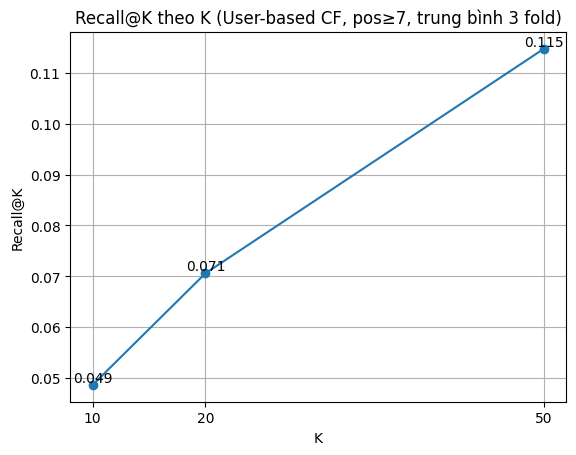

In [10]:
import matplotlib.pyplot as plt

POS = 7
Ks  = [10,20,50]
sub = ub_results_df[ub_results_df['pos_thresh']==POS]

vals = [sub[f'recall@{k}'].mean() for k in Ks]

plt.figure()
plt.plot(Ks, vals, marker='o')
plt.title(f'Recall@K theo K (User-based CF, pos≥{POS}, trung bình 3 fold)')
plt.xlabel('K'); plt.ylabel('Recall@K'); plt.grid(True); plt.xticks(Ks)
for x,y in zip(Ks, vals):
    plt.text(x, y, f'{y:.3f}', ha='center', va='bottom')
plt.show()


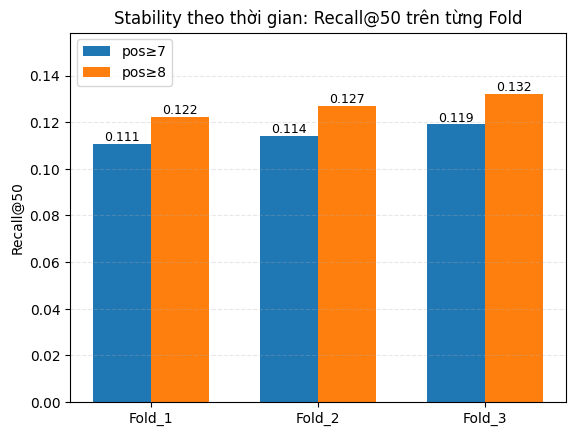

In [11]:
folds_order = ['Fold_1','Fold_2','Fold_3']
bar_width = 0.35
x = range(len(folds_order))

plt.figure()
for i, POS in enumerate([7,8]):
    vals = []
    for f in folds_order:
        s = ub_results_df[(ub_results_df['fold']==f) & (ub_results_df['pos_thresh']==POS)]
        vals.append(s['recall@50'].mean())
    xs = [xx + (i-0.5)*bar_width for xx in x]
    plt.bar(xs, vals, width=bar_width, label=f'pos≥{POS}')
    for xx, v in zip(xs, vals):
        plt.text(xx, v, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.xticks(x, folds_order)
plt.ylabel('Recall@50')
plt.title('Stability theo thời gian: Recall@50 trên từng Fold')
plt.legend(); plt.ylim(0, max(ub_results_df['recall@50'].max(), 0.001)*1.2)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


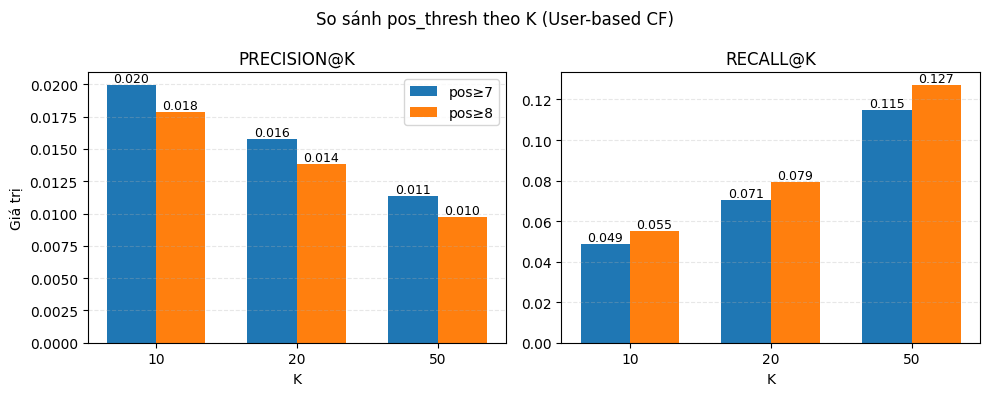

In [12]:
import numpy as np
Ks = [10,20,50]
metrics = ['precision','recall']

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=False)
for ax, metric in zip(axes, metrics):
    for i, POS in enumerate([7,8]):
        vals = []
        for K in Ks:
            sub = ub_results_df[ub_results_df['pos_thresh']==POS]
            vals.append(sub[f'{metric}@{K}'].mean())
        xs = np.arange(len(Ks)) + (i-0.5)*0.35
        ax.bar(xs, vals, width=0.35, label=f'pos≥{POS}')
        for xx, v in zip(xs, vals):
            ax.text(xx, v, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    ax.set_xticks(np.arange(len(Ks)))
    ax.set_xticklabels([str(k) for k in Ks])
    ax.set_title(metric.upper() + '@K')
    ax.set_xlabel('K'); ax.grid(axis='y', linestyle='--', alpha=0.3)
axes[0].set_ylabel('Giá trị')
axes[0].legend()
plt.suptitle('So sánh pos_thresh theo K (User-based CF)')
plt.tight_layout()
plt.show()


👥 Item-Based Collaborative Filtering
tìm item “giống” nhau (cosine trên ma trận item, thường dùng adjusted-cosine), rồi suy điểm cho user đích từ các item tương tự mà user đã chấm.

In [13]:
# ====================== ITEM-BASED CF ======================
import numpy as np, pandas as pd
from scipy import sparse
from sklearn.neighbors import kneighbors_graph

# --- A. Build item matrix (transpose của user-item) ---
def build_ii_matrix(train_df):
    users = train_df['UserID'].astype(int).unique()
    items = train_df['MovieID'].astype(int).unique()
    user_ids = np.sort(users); item_ids = np.sort(items)
    u2row = {u:i for i,u in enumerate(user_ids)}
    i2col = {m:j for j,m in enumerate(item_ids)}

    rows = train_df['UserID'].map(u2row).to_numpy()
    cols = train_df['MovieID'].map(i2col).to_numpy()
    vals = train_df['Rating'].astype(float).to_numpy()

    U,I = len(user_ids), len(item_ids)
    R = sparse.csr_matrix((vals,(rows,cols)), shape=(U,I))

    R_centered = R.copy().tocsr()
    item_means = np.zeros(I, dtype=float)
    for i in range(I):
        s,e = R_centered.indptr[i], R_centered.indptr[i+1]
        if e>s:
            mu = R_centered.data[s:e].mean()
            R_centered.data[s:e] -= mu
            item_means[i] = mu

    seen_rows = {u: set(R[u,:].nonzero()[1]) for u in range(U)}
    return R, user_ids, item_ids, u2row, i2col, item_means, R_centered, seen_rows

# --- B. Similarity giữa items ---
def build_item_neighbor_graph(R_centered, n_neighbors=50):
    W_dist = kneighbors_graph(R_centered.T, n_neighbors=n_neighbors,
                              metric='cosine', mode='distance',
                              include_self=False, n_jobs=-1).tocsr()
    W_sim = W_dist.copy()
    W_sim.data = 1.0 - W_sim.data
    W_sim.data[W_sim.data<0.0] = 0.0
    W_sim.eliminate_zeros()
    return W_sim

# --- C. Gợi ý cho user u (từ các item tương tự mà họ đã xem) ---
def recommend_user_itembased(u_row, R, W_sim, user_means, item_ids, seen_cols, K=20):
    # ratings gốc của user u (dense 1D)
    r_u = R[u_row, :].toarray().ravel()
    rated_idx = np.where(r_u > 0)[0]
    if rated_idx.size == 0:
        return []

    # adjusted by user mean (vì W_sim được tính trên R_centered theo user)
    r_u_centered = r_u - user_means[u_row]

    # sims: độ tương tự của mọi item với các item user đã rate (I x |rated|)
    sims = W_sim[:, rated_idx]

    # dự đoán: bình quân có trọng số theo similarity
    num = sims.multiply(r_u_centered[rated_idx]).sum(axis=1).A1
    denom = np.abs(sims).sum(axis=1).A1 + 1e-12
    scores = (num / denom) + user_means[u_row]  # add-back user mean

    # loại item đã xem trong train
    if u_row in seen_cols and len(seen_cols[u_row]) > 0:
        scores[list(seen_cols[u_row])] = -1e9

    # lấy top-K
    K = min(K, len(scores))
    idx = np.argpartition(scores, -K)[-K:]
    idx = idx[np.argsort(scores[idx])[::-1]]
    return list(zip(item_ids[idx], scores[idx]))

# --- D. Evaluate fold ---
def evaluate_fold_item_based(train_df, test_df, Ks=(10,20,50), pos_thresh=7, n_neighbors=50, min_train_inter=1):
    # LƯU Ý: build_ui_matrix trả về user_means (không phải item_means)
    R, user_ids, item_ids, u2row, i2col, user_means, R_c, seen_cols = build_ui_matrix(train_df)

    # Similarity item-item trên R_c = R đã center theo user (adjusted-cosine)
    W_sim = build_item_neighbor_graph(R_c, n_neighbors=n_neighbors)

    # positives ở test theo ngưỡng
    pos_test = (test_df[test_df['Rating'] >= pos_thresh]
                .groupby('UserID')['MovieID'].apply(lambda s: set(s.values)).to_dict())

    # chỉ evaluate các user có mặt trong train và có tối thiểu min_train_inter tương tác train
    users_eval = []
    for u in pos_test.keys():
        if u in u2row:
            u_row = u2row[u]
            if R.indptr[u_row+1] - R.indptr[u_row] >= min_train_inter:
                users_eval.append(u)

    if not users_eval:
        return {"users_eval": 0, "pos_thresh": pos_thresh}

    out = {"users_eval": len(users_eval), "pos_thresh": pos_thresh}
    for K in Ks:
        HR = P = Rcl = MAP = NDCG = MRR = 0.0
        for u in users_eval:
            u_row = u2row[u]
            ranked = recommend_user_itembased(
                u_row, R, W_sim, user_means, item_ids, seen_cols, K
            )
            truth = pos_test[u]
            pk, rk = precision_recall_at_k(truth, ranked, k=K)
            HR    += hitrate_at_k(truth, ranked, k=K)
            P     += pk
            Rcl   += rk
            MAP   += average_precision_at_k(truth, ranked, k=K)
            NDCG  += ndcg_at_k(truth, ranked, k=K)
            MRR   += mrr_at_k(truth, ranked, k=K)
        n = len(users_eval)
        out.update({
            f'hit@{K}':       float(HR/n),
            f'precision@{K}': float(P/n),
            f'recall@{K}':    float(Rcl/n),
            f'map@{K}':       float(MAP/n),
            f'ndcg@{K}':      float(NDCG/n),
            f'mrr@{K}':       float(MRR/n),
        })
    return out

# --- E. Runner ---
POS_LIST=(7,8); KS=(10,20,50); N_NEI=50
ib_results=[]
print("\n=== RUN Item-Based CF ===")
for fold_name, splits in folds.items():
    train_df,test_df=splits['train'],splits['test']
    print(f"\n[Fold] {fold_name}: train={len(train_df):,} | test={len(test_df):,}")
    for POS in POS_LIST:
        metrics=evaluate_fold_item_based(train_df,test_df,Ks=KS,pos_thresh=POS,n_neighbors=N_NEI)
        metrics['fold']=fold_name;metrics['pos_thresh']=POS
        ib_results.append(metrics)
        present=[k for k in metrics if '@'in k]
        print(f"  POS≥{POS} | users_eval={metrics.get('users_eval',0)} | "+
              f"{ {k:round(metrics[k],4) for k in present} }")

ib_results_df=pd.DataFrame(ib_results)
print("\n=== Tổng hợp (mean theo pos_thresh, qua fold) ===")
print(ib_results_df.groupby('pos_thresh')[[c for c in ib_results_df.columns if '@'in c]].mean().round(4))



=== RUN Item-Based CF ===

[Fold] Fold_1: train=655,319 | test=263,700
  POS≥7 | users_eval=23355 | {'hit@10': 0.0585, 'precision@10': 0.0067, 'recall@10': 0.017, 'map@10': 0.0075, 'ndcg@10': 0.0324, 'mrr@10': 0.0247, 'hit@20': 0.0809, 'precision@20': 0.0048, 'recall@20': 0.0244, 'map@20': 0.0078, 'ndcg@20': 0.038, 'mrr@20': 0.0262, 'hit@50': 0.1215, 'precision@50': 0.0031, 'recall@50': 0.0363, 'map@50': 0.0082, 'ndcg@50': 0.0458, 'mrr@50': 0.0275}
  POS≥8 | users_eval=22108 | {'hit@10': 0.0546, 'precision@10': 0.0062, 'recall@10': 0.0202, 'map@10': 0.0088, 'ndcg@10': 0.0306, 'mrr@10': 0.0235, 'hit@20': 0.0756, 'precision@20': 0.0044, 'recall@20': 0.0284, 'map@20': 0.0093, 'ndcg@20': 0.0358, 'mrr@20': 0.0249, 'hit@50': 0.1126, 'precision@50': 0.0028, 'recall@50': 0.0415, 'map@50': 0.0097, 'ndcg@50': 0.0429, 'mrr@50': 0.0261}

[Fold] Fold_2: train=698,450 | test=220,569
  POS≥7 | users_eval=23205 | {'hit@10': 0.0512, 'precision@10': 0.0058, 'recall@10': 0.0174, 'map@10': 0.0077, 'ndcg@

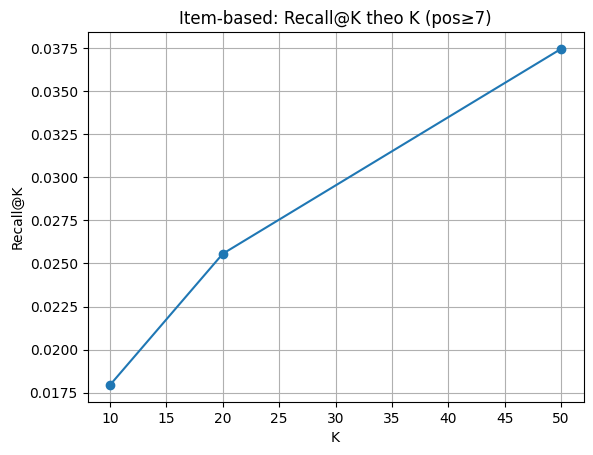

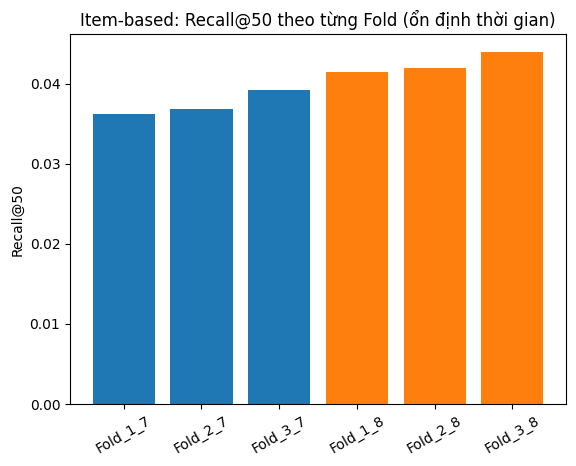

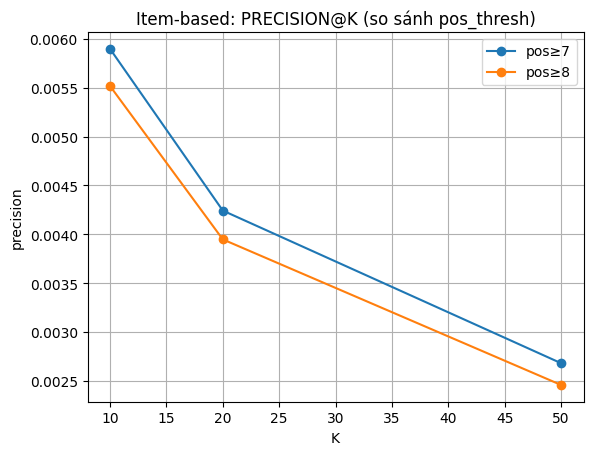

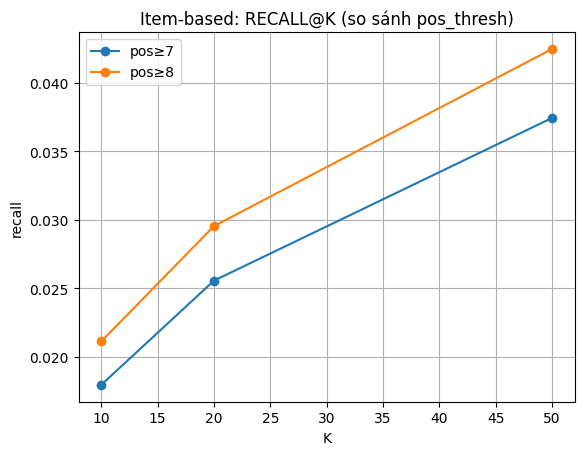

In [14]:
# (1) Recall@K theo K
POS=7; Ks=[10,20,50]
vals=[ib_results_df[ib_results_df['pos_thresh']==POS][f'recall@{k}'].mean() for k in Ks]
plt.figure(); plt.plot(Ks,vals,marker='o'); plt.title(f'Item-based: Recall@K theo K (pos≥{POS})')
plt.xlabel('K'); plt.ylabel('Recall@K'); plt.grid(True); plt.show()

# (2) Stability qua fold
folds_order=['Fold_1','Fold_2','Fold_3']
for POS in [7,8]:
    plt.bar([f+"_"+str(POS) for f in folds_order],
            [ib_results_df[(ib_results_df['fold']==f)&(ib_results_df['pos_thresh']==POS)]['recall@50'].mean()
             for f in folds_order])
plt.title("Item-based: Recall@50 theo từng Fold (ổn định thời gian)")
plt.ylabel('Recall@50'); plt.xticks(rotation=30); plt.show()

# (3) So sánh pos_thresh (Precision vs Recall)
Ks=[10,20,50]
for metric in ['precision','recall']:
    for POS in [7,8]:
        vals=[ib_results_df[ib_results_df['pos_thresh']==POS][f'{metric}@{k}'].mean() for k in Ks]
        plt.plot(Ks,vals,marker='o',label=f'pos≥{POS}')
    plt.title(f'Item-based: {metric.upper()}@K (so sánh pos_thresh)')
    plt.xlabel('K');plt.ylabel(metric);plt.legend();plt.grid(True);plt.show()


💡TRUNCATED SVD: học đặc trưng ẩn (latent features) — ví dụ:

Một người thích phim hành động → cũng có thể thích phim siêu anh hùng,
Mà không cần 2 phim đó phải có cùng người đánh giá.

In [15]:
# ====================== TRUNCATED SVD CF (MODEL-BASED) ======================
import numpy as np, pandas as pd
from scipy import sparse
from sklearn.decomposition import TruncatedSVD

# --- A. Build UI matrix + mean-center (dùng lại của bạn) ---
# (nếu đã import ở trên rồi thì bỏ qua phần định nghĩa lại)
def build_ui_matrix(train_df):
    users = train_df['UserID'].astype(int).unique()
    items = train_df['MovieID'].astype(int).unique()
    user_ids = np.sort(users); item_ids = np.sort(items)
    u2row = {u:i for i,u in enumerate(user_ids)}
    i2col = {m:j for j,m in enumerate(item_ids)}

    rows = train_df['UserID'].map(u2row).to_numpy()
    cols = train_df['MovieID'].map(i2col).to_numpy()
    vals = train_df['Rating'].astype(float).to_numpy()

    U,I = len(user_ids), len(item_ids)
    R = sparse.csr_matrix((vals,(rows,cols)), shape=(U,I))

    R_centered = R.copy().tocsr()
    user_means = np.zeros(U, dtype=float)
    for u in range(U):
        s,e = R_centered.indptr[u], R_centered.indptr[u+1]
        if e>s:
            mu = R_centered.data[s:e].mean()
            R_centered.data[s:e] -= mu
            user_means[u] = mu

    # các item đã xem bởi từng user (để loại khỏi gợi ý)
    seen_cols = {u: set(R.indices[R.indptr[u]:R.indptr[u+1]]) for u in range(U)}
    return R, user_ids, item_ids, u2row, i2col, user_means, R_centered, seen_cols

# --- B. Train Truncated SVD trên R_centered ---
def train_truncated_svd(R_centered, n_components=64, random_state=42):
    """
    Fit TruncatedSVD trên ma trận đã trừ mean theo user.
    Trả về:
      U_s : (U x k) ~ U * Sigma
      Vt  : (k x I) ~ V^T
      svd : model đã fit (để dùng lại nếu cần)
    """
    svd = TruncatedSVD(n_components=n_components, random_state=random_state)
    U_s = svd.fit_transform(R_centered)   # U * Sigma
    Vt  = svd.components_                # V^T
    return U_s, Vt, svd

# --- C. Recommend cho 1 user từ SVD ---
def recommend_user_svd(u_row, U_s, Vt, user_means, seen_cols, item_ids, K=20):
    """
    Dự đoán điểm centered ~ (U * Sigma) @ V^T; rồi cộng bù mean của user.
    """
    # hàng dự đoán cho user u (centered)
    scores_centered = U_s[u_row, :] @ Vt           # shape (I,)
    scores = scores_centered + user_means[u_row]   # add-back user mean

    # loại item đã xem
    if u_row in seen_cols and len(seen_cols[u_row])>0:
        idx_seen = np.fromiter(seen_cols[u_row], dtype=int, count=len(seen_cols[u_row]))
        scores[idx_seen] = -1e9

    # top-K
    K = min(K, scores.shape[0])
    top_idx = np.argpartition(scores, -K)[-K:]
    top_idx = top_idx[np.argsort(scores[top_idx])[::-1]]
    mids = item_ids[top_idx]
    return list(zip(mids, scores[top_idx]))

# --- D. Evaluate 1 fold (giữ nguyên hệ metric như 2 mode trước) ---
def evaluate_fold_svd(train_df, test_df, Ks=(10,20,50), pos_thresh=7,
                      n_components=64, min_train_inter=1, random_state=42):
    # 1) build + center theo user
    R, user_ids, item_ids, u2row, i2col, user_means, R_centered, seen_cols = build_ui_matrix(train_df)

    # 2) fit SVD
    U_s, Vt, _ = train_truncated_svd(R_centered, n_components=n_components, random_state=random_state)

    # 3) positives ở test
    pos_test = (test_df[test_df['Rating']>=pos_thresh]
                .groupby('UserID')['MovieID'].apply(lambda s:set(s.values)).to_dict())

    # 4) user đủ điều kiện evaluate
    users_eval = []
    for u in pos_test.keys():
        if u in u2row:
            u_row = u2row[u]
            if R.indptr[u_row+1]-R.indptr[u_row] >= min_train_inter:
                users_eval.append(u)
    if not users_eval:
        return {"users_eval":0, "pos_thresh":pos_thresh}

    out = {"users_eval":len(users_eval), "pos_thresh":pos_thresh}
    for K in Ks:
        HR=P=Rcl=MAP=NDCG=MRR=0.0
        for u in users_eval:
            u_row = u2row[u]
            ranked = recommend_user_svd(u_row, U_s, Vt, user_means, seen_cols, item_ids, K=K)
            truth  = pos_test[u]
            pk, rk = precision_recall_at_k(truth, ranked, k=K)
            HR    += hitrate_at_k(truth, ranked, k=K)
            P     += pk; Rcl += rk
            MAP   += average_precision_at_k(truth, ranked, k=K)
            NDCG  += ndcg_at_k(truth, ranked, k=K)
            MRR   += mrr_at_k(truth, ranked, k=K)
        n = len(users_eval)
        out.update({
            f'hit@{K}':       float(HR/n),
            f'precision@{K}': float(P/n),
            f'recall@{K}':    float(Rcl/n),
            f'map@{K}':       float(MAP/n),
            f'ndcg@{K}':      float(NDCG/n),
            f'mrr@{K}':       float(MRR/n),
        })
    return out

# --- E. Runner ---
# giả sử bạn đã có: data, folds, meta từ load_checkpoint(BASE_DIR) ở phần trước
print("\n=== RUN Truncated SVD CF ===")
POS_LIST = (7, 8); KS = (10,20,50); N_COMP = 64; MIN_INT = 1
svd_results = []
for fold_name in sorted(folds.keys()):
    train_df, test_df = folds[fold_name]['train'], folds[fold_name]['test']
    print(f"\n[Fold] {fold_name}: train={len(train_df):,} | test={len(test_df):,}")
    for POS in POS_LIST:
        metrics = evaluate_fold_svd(train_df, test_df, Ks=KS, pos_thresh=POS,
                                    n_components=N_COMP, min_train_inter=MIN_INT, random_state=42)
        metrics['fold']=fold_name; metrics['pos_thresh']=POS; metrics['n_components']=N_COMP
        svd_results.append(metrics)
        present = sorted(k for k in metrics if '@' in k)
        print(f"  POS ≥ {POS} | users_eval={metrics.get('users_eval',0)} | "
              f"{ {k:round(metrics[k],4) for k in present} }")

svd_results_df = pd.DataFrame(svd_results)
print("\n=== Tổng hợp SVD (mean theo pos_thresh, qua fold) ===")
if not svd_results_df.empty:
    metric_cols = [c for c in svd_results_df.columns if any(c.startswith(m) for m in ['hit@','precision@','recall@','map@','ndcg@','mrr@'])]
    print(svd_results_df.groupby('pos_thresh')[metric_cols].mean().round(4))
else:
    print("[WARN] svd_results_df rỗng.")



=== RUN Truncated SVD CF ===

[Fold] Fold_1: train=655,319 | test=263,700
  POS ≥ 7 | users_eval=23355 | {'hit@10': 0.1964, 'hit@20': 0.2834, 'hit@50': 0.4186, 'map@10': 0.0215, 'map@20': 0.0222, 'map@50': 0.0242, 'mrr@10': 0.0822, 'mrr@20': 0.0882, 'mrr@50': 0.0925, 'ndcg@10': 0.1079, 'ndcg@20': 0.1286, 'ndcg@50': 0.1539, 'precision@10': 0.0246, 'precision@20': 0.0206, 'precision@50': 0.0156, 'recall@10': 0.0433, 'recall@20': 0.0682, 'recall@50': 0.1198}
  POS ≥ 8 | users_eval=22108 | {'hit@10': 0.1793, 'hit@20': 0.26, 'hit@50': 0.3906, 'map@10': 0.0244, 'map@20': 0.0259, 'map@50': 0.0282, 'mrr@10': 0.0749, 'mrr@20': 0.0804, 'mrr@50': 0.0847, 'ndcg@10': 0.0984, 'ndcg@20': 0.1177, 'ndcg@50': 0.1425, 'precision@10': 0.0219, 'precision@20': 0.0181, 'precision@50': 0.0134, 'recall@10': 0.0521, 'recall@20': 0.0803, 'recall@50': 0.1372}

[Fold] Fold_2: train=698,450 | test=220,569
  POS ≥ 7 | users_eval=23205 | {'hit@10': 0.1754, 'hit@20': 0.2587, 'hit@50': 0.3895, 'map@10': 0.0214, 'map@2

VÍ DỤ USER 1 CHO USER, ITEM BASED VÀ TRUNCATED SVD

In [16]:
# --- Config ---
FOLD_NAME = "Fold_1"     # đổi sang Fold_2 / Fold_3 nếu muốn
USER_ID   = 1            # user cần xem ví dụ
K         = 10           # số phim gợi ý
N_NEI     = 50           # số hàng xóm kNN

# --- Lấy train/test của fold ---
train_df = folds[FOLD_NAME]["train"][["UserID","MovieID","Rating","Timestamp"]].copy()
test_df  = folds[FOLD_NAME]["test"][["UserID","MovieID","Rating","Timestamp"]].copy()

# --- Build ma trận & đồ thị hàng xóm ---
R, user_ids, item_ids, u2row, i2col, user_means, R_centered, seen_cols = build_ui_matrix(train_df)
W_sim = build_user_neighbor_graph(R_centered, n_neighbors=N_NEI)

# --- Kiểm tra user có trong train không ---
if USER_ID not in u2row:
    raise ValueError(f"User {USER_ID} không có trong tập train của {FOLD_NAME}.")

u_row = u2row[USER_ID]

# --- Gợi ý top-K cho user ---
pred = recommend_user_row(
    u_row=u_row,
    W_sim=W_sim,
    R_centered=R_centered,
    user_means=user_means,
    seen_cols=seen_cols,
    item_ids=item_ids,
    K=K
)  # -> list[(movie_id, score)]

# --- Map sang tiêu đề phim để đọc dễ ---
movie_title = dict(zip(data["MovieID"], data["Title"]))
pred_pretty = [(mid, movie_title.get(mid, f"Movie {mid}"), float(score)) for mid, score in pred]

print(f"[{FOLD_NAME}] Gợi ý cho user {USER_ID} (top-{K}):")
for i, (mid, title, s) in enumerate(pred_pretty, 1):
    print(f"{i:>2}. {mid:<8} | {s:5.2f} | {title}")

# --- (Tuỳ chọn) Xem ground-truth: các phim user này thật sự thích trong test ---
POS_THRESH = 7  # hoặc 8
truth = (test_df[(test_df["UserID"]==USER_ID) & (test_df["Rating"]>=POS_THRESH)]["MovieID"].tolist())
truth_titles = [movie_title.get(m, str(m)) for m in truth]
print(f"\nPhim user {USER_ID} thích thật (test, rating>={POS_THRESH}):")
for m,t in zip(truth, truth_titles):
    print(f"- {m} | {t}")

[Fold_1] Gợi ý cho user 1 (top-10):

Phim user 1 thích thật (test, rating>=7):


In [17]:
# ==== Config ====
FOLD_NAME = "Fold_1"   # hoặc "Fold_2", "Fold_3"
USER_ID   = 1
N_NEI     = 50         # số hàng xóm item
K         = 10         # số phim gợi ý
POS_THRESH = 7         # để soi ground-truth trong test

# ==== Lấy dữ liệu của fold ====
train_df = folds[FOLD_NAME]["train"][["UserID","MovieID","Rating","Timestamp"]].copy()
test_df  = folds[FOLD_NAME]["test"][["UserID","MovieID","Rating","Timestamp"]].copy()

# ==== Build ma trận & similarity item–item ====
# (hàm build_ui_matrix phải trả về: R, user_ids, item_ids, u2row, i2col, user_means, R_centered, seen_cols)
R, user_ids, item_ids, u2row, i2col, user_means, R_centered, seen_cols = build_ui_matrix(train_df)

# kNN cosine giữa các item (adjusted-cosine vì dùng R_centered)
W_sim = build_item_neighbor_graph(R_centered, n_neighbors=N_NEI)

# ==== Recommend cho 1 user ====
if USER_ID not in u2row:
    raise ValueError(f"User {USER_ID} không có trong train của {FOLD_NAME}.")

u_row = u2row[USER_ID]

# recommend_user_itembased(u_row, R, W_sim, user_means, item_ids, seen_cols, K)
pred = recommend_user_itembased(u_row, R, W_sim, user_means, item_ids, seen_cols, K=K)
# -> list[(movie_id, score)]

# ==== In đẹp: map sang tiêu đề phim ====
movie_title = dict(zip(data["MovieID"], data["Title"]))
print(f"[{FOLD_NAME}] Item-Based CF — gợi ý cho user {USER_ID} (top-{K})")
for i, (mid, s) in enumerate(pred, 1):
    print(f"{i:>2}. {mid:<8} | {float(s):5.2f} | {movie_title.get(mid, f'Movie {mid}')}")

# ==== (Tuỳ chọn) Ground-truth trong test để đối chiếu ====
truth_ids = test_df[(test_df["UserID"]==USER_ID) & (test_df["Rating"]>=POS_THRESH)]["MovieID"].tolist()
if truth_ids:
    print(f"\nPhim user {USER_ID} thích thật trong test (rating>={POS_THRESH}):")
    for mid in truth_ids:
        print(f"- {mid} | {movie_title.get(mid, f'Movie {mid}')}")
else:
    print(f"\nUser {USER_ID} không có phim 'thích' (rating>={POS_THRESH}) trong test của {FOLD_NAME}.")


[Fold_1] Item-Based CF — gợi ý cho user 1 (top-10)
 1. 8        |  8.00 | Edison Kinetoscopic Record Of A Sneeze (1894)
 2. 15831978 |  8.00 | Cash (2021)
 3. 15655276 |  8.00 | Yara (2021)
 4. 15293256 |  8.00 | The River Runner (2021)
 5. 15219436 |  8.00 | 200 Pounds (2021)
 6. 15141288 |  8.00 | If I Can X27;T Have Love, I Want Power (2021)
 7. 15112954 |  8.00 | Dal Pianeta Degli Umani (2021)
 8. 15101946 |  8.00 | Untold: Caitlyn Jenner (2021)
 9. 15097216 |  8.00 | Jai Bhim (2021)
10. 15095938 |  8.00 | Blood Brothers: Malcolm X Amp; Muhammad Ali (2021)

User 1 không có phim 'thích' (rating>=7) trong test của Fold_1.


In [18]:
# === EXPORT CF (user-based) PER-FOLD (đặt ở CUỐI notebook CF) ===
import pandas as pd
from pathlib import Path

BASE_DIR = Path(r"C:\Users\ADMIN\Documents\Khóa luận\MovieTweetings Dataset\data\processed\20251102-161934")
CF_DIR = BASE_DIR / "cf_out"
CF_DIR.mkdir(exist_ok=True)

def export_cf_user_based_fold(fold_name, train_df, K=200, n_neighbors=50, min_train_inter=1):
    R, user_ids, item_ids, u2row, i2col, user_means, R_centered, seen_cols = build_ui_matrix(train_df)
    W_sim = build_user_neighbor_graph(R_centered, n_neighbors=n_neighbors)
    recs = {}
    for u, u_row in u2row.items():
        if (R.indptr[u_row+1] - R.indptr[u_row]) < min_train_inter:
            continue
        recs[u] = recommend_user_row(u_row, W_sim, R_centered, user_means, seen_cols, item_ids, K=K)

    rows = []
    for u, pairs in recs.items():
        for iid, s in pairs:
            rows.append((u, iid, float(s)))
    df = pd.DataFrame(rows, columns=["UserID","MovieID","score_cf"])
    out_path = CF_DIR / f"cf_{fold_name}.parquet"
    df.to_parquet(out_path, index=False)
    print("✅ CF(user) saved:", out_path, "| rows:", len(df))

for fold_name in ["Fold_1","Fold_2","Fold_3"]:
    export_cf_user_based_fold(fold_name, folds[fold_name]["train"], K=200, n_neighbors=50)


✅ CF(user) saved: C:\Users\ADMIN\Documents\Khóa luận\MovieTweetings Dataset\data\processed\20251102-161934\cf_out\cf_Fold_1.parquet | rows: 7364400
✅ CF(user) saved: C:\Users\ADMIN\Documents\Khóa luận\MovieTweetings Dataset\data\processed\20251102-161934\cf_out\cf_Fold_2.parquet | rows: 7373200
✅ CF(user) saved: C:\Users\ADMIN\Documents\Khóa luận\MovieTweetings Dataset\data\processed\20251102-161934\cf_out\cf_Fold_3.parquet | rows: 7399600


In [21]:
# === EXPORT CF (Truncated SVD) PER-FOLD — version không nổ RAM ===
import numpy as np
import pandas as pd
from pathlib import Path

CF_DIR = BASE_DIR / "cf_out"
CF_DIR.mkdir(exist_ok=True)

def export_cf_svd_fold(fold_name, train_df, K=200,
                       n_components=64, min_train_inter=1):
    # 1) build UI matrix + center theo user
    R, user_ids, item_ids, u2row, i2col, user_means, R_centered, seen_cols = build_ui_matrix(train_df)

    # 2) train truncated SVD trên R_centered
    U_s, Vt, _ = train_truncated_svd(R_centered, n_components=n_components, random_state=42)

    # 3) recommend cho từng user bằng recommend_user_svd (không dựng R_hat full)
    recs = {}
    for u, u_row in u2row.items():
        # bỏ user quá ít tương tác
        if R.indptr[u_row+1] - R.indptr[u_row] < min_train_inter:
            continue
        ranked = recommend_user_svd(u_row, U_s, Vt, user_means, seen_cols, item_ids, K=K)
        recs[u] = ranked

    # 4) convert thành bảng [UserID, MovieID, score_cf] và lưu parquet
    rows = []
    for u, pairs in recs.items():
        for iid, s in pairs:
            rows.append((u, iid, float(s)))

    df = pd.DataFrame(rows, columns=["UserID","MovieID","score_cf"])
    out_path = CF_DIR / f"svd_{fold_name}.parquet"
    df.to_parquet(out_path, index=False)
    print(f"✓ CF(SVD) saved:", out_path, "| rows:", len(df))

# RUN 3 FOLDS
for fold_name in ["Fold_1","Fold_2","Fold_3"]:
    export_cf_svd_fold(fold_name, folds[fold_name]["train"],
                       K=200, n_components=64, min_train_inter=1)


✓ CF(SVD) saved: C:\Users\ADMIN\Documents\Khóa luận\MovieTweetings Dataset\data\processed\20251102-161934\cf_out\svd_Fold_1.parquet | rows: 14329600
✓ CF(SVD) saved: C:\Users\ADMIN\Documents\Khóa luận\MovieTweetings Dataset\data\processed\20251102-161934\cf_out\svd_Fold_2.parquet | rows: 14329600
✓ CF(SVD) saved: C:\Users\ADMIN\Documents\Khóa luận\MovieTweetings Dataset\data\processed\20251102-161934\cf_out\svd_Fold_3.parquet | rows: 14329600
